Copyright (c) 2018 [Geosoft Inc.](geosoft.com)

https://github.com/GeosoftInc/gxpy/blob/master/README.md

[BSD 2-clause License](https://github.com/GeosoftInc/gxpy/blob/master/LICENSE)

# Grid FFT

Demonstrate the application of FFT (Fast Fourier Transform) to gridded potential-field data.

 1. [TMI Grid](#TMI-Grid)
 2. [Create a GridFFT instance](#Create-a-GridFFT-instance)
 3. [Simple Filter - Vertical Derivative](#Simple-Filter---Vertical-Derivative)
 4. [Power Spectrum](#Power-Spectrum)
 5. [Apply multiple filters](#Apply-multiple-filters)
 6. [2D power spectrum](#2D-power-spectrum)
 7. [The expanded and filled grid](#The-expanded-and-filled-grid)

## TMI Grid

We will use the Total Magnetic Intensity (TMI) data from the Black Hills Norite in South Australia.

Reference: https://doi.org/10.1071/ASEG2016ab115

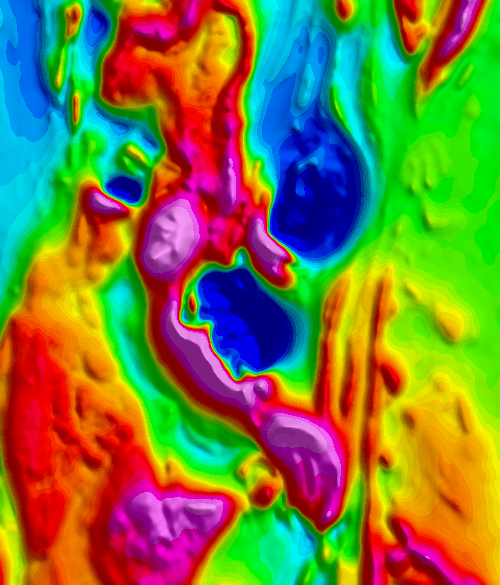

In [1]:
%matplotlib notebook
import pylab as plt
import numpy as np
import geosoft.gxpy.gx as gx
import geosoft.gxpy.utility as gxu
import geosoft.gxpy.grid as gxgrd
import geosoft.gxpy.grid_utility as gxgrdu

from IPython.display import Image

gxc = gx.GXpy()
gxu.check_version('9.4.0b0')

# get the sample data from github
url = 'https://github.com/GeosoftInc/gxpy/raw/master/examples/data/'
grid = 'bhn_tmi_250m.grd'
gxu.url_retrieve(url + grid)
gxu.url_retrieve(url + grid + '.gi')
gxu.url_retrieve(url + grid + '.xml')

grd = gxgrd.Grid.open(grid)
Image(grd.image_file(shade=True, pix_width=500))

## Create a GridFFT instance

To work with FFT filters, first create a GridFFT instance from the grid.  The instance will contain a reference to the source grid, an expanded and filled grid instance, and a descrete Fourier transform stored as (real, imaginary) vaule in a wavenumber *(u, v)* grid.  Wavenumbers are cycles/distance_unit.

In [2]:
import geosoft.gxpy.grid_fft as gxfft
fft = gxfft.GridFFT(grd)

## Simple Filter - Vertical Derivative

Here we apply a simple vertical derivative filter and display the result.  Filters are defined by providing the 4-letter mnemonic filter name with parameters as described in the `magmap.con` control file:

https://github.com/GeosoftInc/gxc/blob/master/reference/con_files/magmap.con

The filter for a vertical derivative is 'DRVZ 1', or ('DRVZ', 1) which may be a more convenient form in a program that is determining filter parameters dynamically.

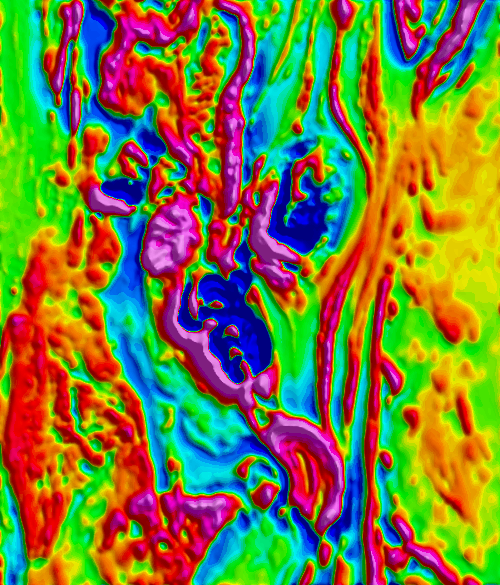

In [3]:
# apply a filter
fft.filter(['DRVZ 1'])

# fft.result_grid() can be called to get a grid instance of the filtered result
Image(fft.result_grid().image_file(shade=True, pix_width=500))

## Power Spectrum

The power spectrum can be viewed either in radially averaged form, or as a grid of the transform in *(u, v)* wavenumber space. Here we will show the original spectrum and the filterd spectum for comparison using matplotlig.

average spectral density (source, filtered): (23.4286, 9.38861)


<IPython.core.display.Javascript object>


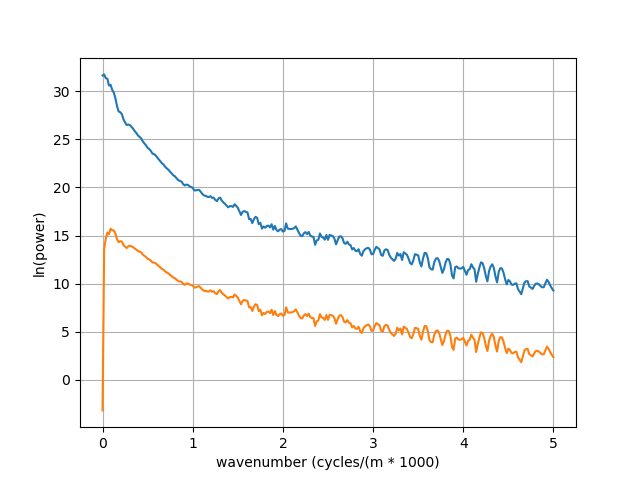

In [4]:
# this returs a numpy array shaped (n, 5), where each element contains the
# wavenumber, number_samples, log(average_power), depth_3 and depth_5)
source_spectrum = fft.radially_averaged_spectrum()
filter_spectrum = fft.radially_averaged_spectrum(trn=gxfft.FILTERED)

# the power is relative to the average density
print('average spectral density (source, filtered): ({}, {})'.
      format(fft.log_average_spectral_density(), fft.log_average_spectral_density(trn=gxfft.FILTERED)))

fig = plt.figure()
plt.plot(source_spectrum[:, gxfft.WAVENUMBER], source_spectrum[:, gxfft.LOG_POWER])
plt.plot(filter_spectrum[:, gxfft.WAVENUMBER], filter_spectrum[:, gxfft.LOG_POWER])
plt.ylabel('ln(power)')
plt.xlabel('wavenumber (cycles/({} * 1000)'.format(grd.coordinate_system.unit_of_measure))
plt.axis()
plt.grid()
plt.show()

## Apply multiple filters

Here we apply two filters - an upward continuation and a vertical derivative.  In this case we will use the tuple form to describe an upward-continuation of 250 m:

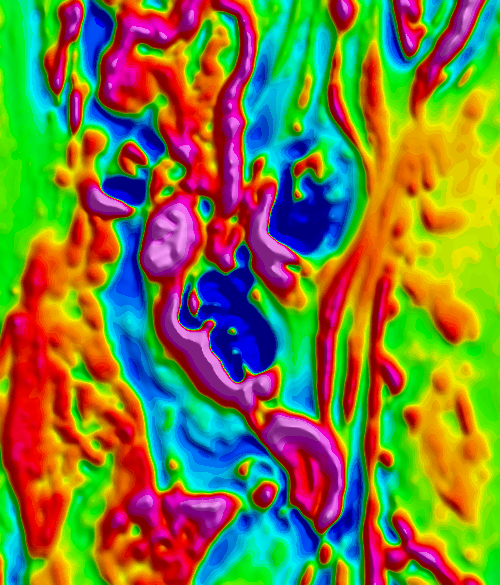

In [5]:
# apply a filter
fft.filter([('CNUP', 250), 'DRVZ 1'])

# fft.result_grid() can be called to get a grid instance of the filtered result
Image(fft.result_grid().image_file(shade=True, pix_width=500))

Filters can also be applied to the currently filtered state by specifying the source transform with the `trn=gxfft.FILTERED` parameter:

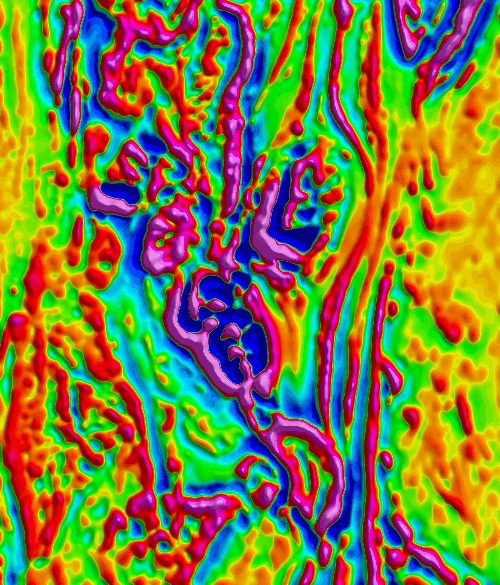

In [6]:
# apply a vertical derivative to the current filtered transform, effective making 
# this a second vertical derivative of the upward-continued data.
fft.filter(['DRVZ 1'], trn=gxfft.FILTERED)

# fft.result_grid() can be called to get a grid instance of the filtered result
Image(fft.result_grid().image_file(shade=True, pix_width=500))

## 2D power spectrum

The `spectrum_griid()` method returns the FFT power spectrum as a grid of the log-power in wavenumber space, with wavenumber *u* in the x direction and wavenumber *v* in the y direction. Wavenumbers in the grid are in cycles/grid_distance_unit, and grid values are the log amplitude of the power at each *(u, v)* location.  The spectrum is symetric across the *v* axis and only the *+u* part appears.

Log-power spectrum, wavenumber increment is cycles/m: (1.785714285714286e-05, 1.785714285714286e-05)


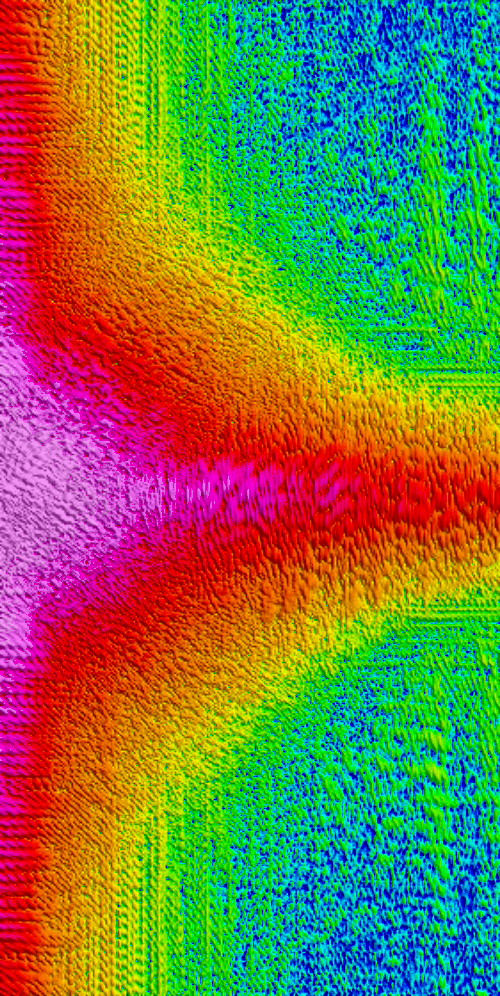

In [7]:
print('Log-power spectrum, wavenumber increment is cycles/{}: ({}, {})'.
      format(grd.coordinate_system.unit_of_measure, fft.du, fft.dv))
Image(fft.spectrum_grid().image_file(shade=True, pix_width=500))

To see the filtered specturm, specity `trn=gxfft.FILTERED`:

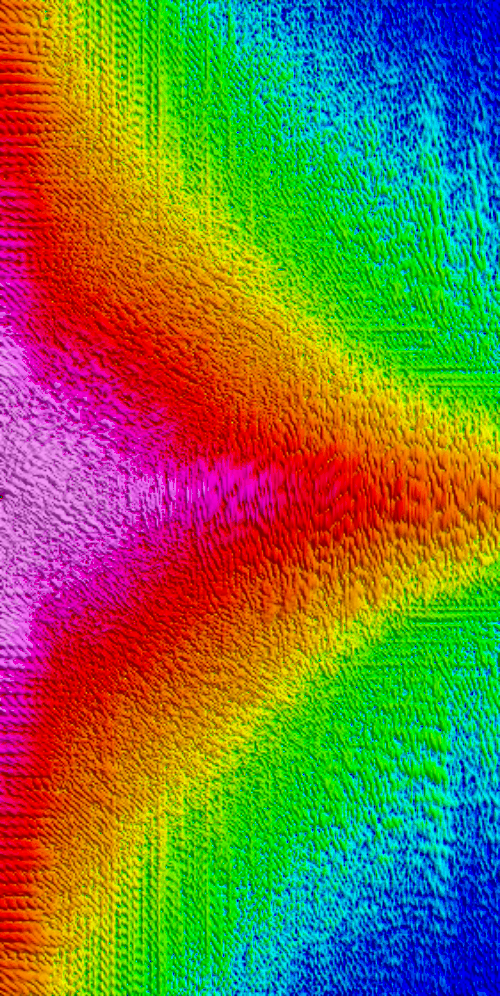

In [8]:
Image(fft.spectrum_grid(trn=gxfft.FILTERED).image_file(shade=True, pix_width=500))

## The expanded and filled grid

The FFT transform is aplied to an expanded and filled grid with no blank areas, and this grid continuous on the left-right edge and the bottom-top edge.  The expanding and filling process is as follows:

1. A first-order trend is removed, and the trend coefficients are filtered together with the 0 wavenumber.

2. A 2.5% buffer is added around the grid (or a minimum of 5 cells) and all blank areas in the grid are interpolated using a minimum curvature surface.

3. The grid is expanded by the `expand=`parameter

4. The expanded area in filled using a maximum-entropy method that minimizes distortion of the radial power spectrum.

When recovering the filtered result, the expanded and filled areas are trimmed and the resulting grid matches the shape and size of the source grid.

The `expanded_filled_grid` property can be used to work with the filled-grid.


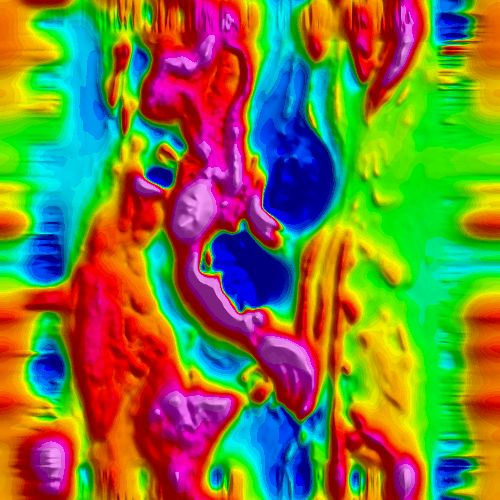

In [9]:
Image(fft.expanded_filled_grid.image_file(shade=True, pix_width=500))